In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from difflib import get_close_matches
from collections import defaultdict
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

### Reading the input

In [256]:

df = pd.read_csv("/kaggle/input/parkinglot/parkingLot.csv", parse_dates=True)

# Convert the 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by 'timestamp' column in ascending order
df = df.sort_values(by='timestamp').reset_index(drop=True)

# Part b

### maintenance period adjustment and daily average time spent calculation

<Axes: xlabel='1'>

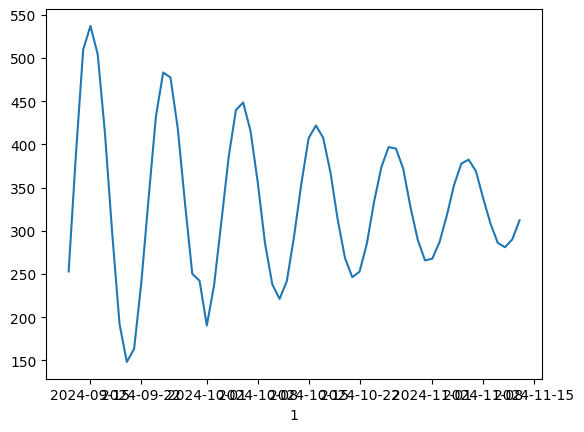

In [257]:

# Mark maintenance periods as intervals
df['is_maintenance'] = df['vehicle_no'].isna() & df['camera_id'].notna()

maintenance_intervals = []

# Track start and end of each maintenance period
for _, group in df[df['is_maintenance']].groupby((~df['is_maintenance']).cumsum()):
    start = group['timestamp'].iloc[0]
    end = group['timestamp'].iloc[-1]
    maintenance_intervals.append((start, end))


def is_during_maintenance(timestamp, maintenance_intervals):
    return any(start <= timestamp <= end for start, end in maintenance_intervals)

# Add flags for entries and exits during maintenance
df['is_entry_during_maintenance'] = df.apply(lambda row: is_during_maintenance(row['timestamp'], maintenance_intervals) if row['camera_id'] == 1 else False, axis=1)
df['is_exit_during_maintenance'] = df.apply(lambda row: is_during_maintenance(row['timestamp'], maintenance_intervals) if row['camera_id'] == 2 else False, axis=1)

# Remove entries with incomplete pairs if one part falls in maintenance period
df_valid = df[~((df['is_entry_during_maintenance']) | (df['is_exit_during_maintenance']))]

df_pivot = df_valid.pivot_table(index='vehicle_no', columns='camera_id', values='timestamp', aggfunc='first')
df_pivot.dropna(inplace=True)  # Only complete pairs remain

# Calculate time spent for valid pairs
df_pivot['time_spent'] = (df_pivot[2] - df_pivot[1]).dt.total_seconds() / 60  # in minutes

daily_entries = df_valid[df_valid['camera_id'] == 1].groupby(df_valid['timestamp'].dt.date).size()

daily_avg_time = df_pivot.groupby(df_pivot[1].dt.date)['time_spent'].mean()


avg_time = daily_avg_time.values

daily_avg_time.plot()

### analyzing the data for avg-time spent on mall each day

In [258]:


dftest = adfuller(avg_time, autolag='AIC')
print("1. ADF : ",dftest[0])
print("2. P-value : ",dftest[1])
print("3. Num of lags : ", dftest[2])
print("4. Num of observations used for ADF Regression and Critical Values Calculation: ", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t", key, ": ", val)

1. ADF :  -7.698588085413473
2. P-value :  1.3582979257157843e-11
3. Num of lags :  5
4. Num of observations used for ADF Regression and Critical Values Calculation:  57
5. Critical Values :
	 1% :  -3.5506699942762414
	 5% :  -2.913766394626147
	 10% :  -2.5946240473991997


### analyzing ACF and PACF for avg-time spent each day on mall

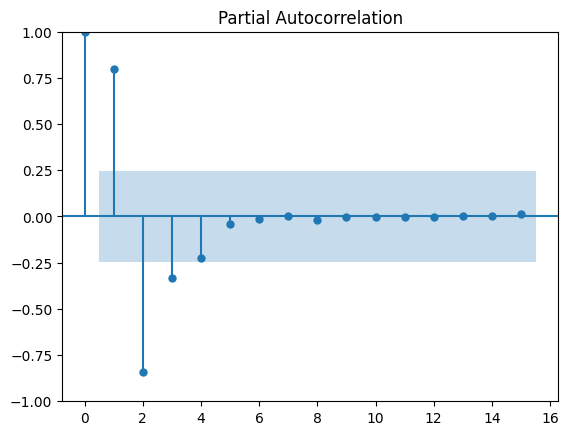

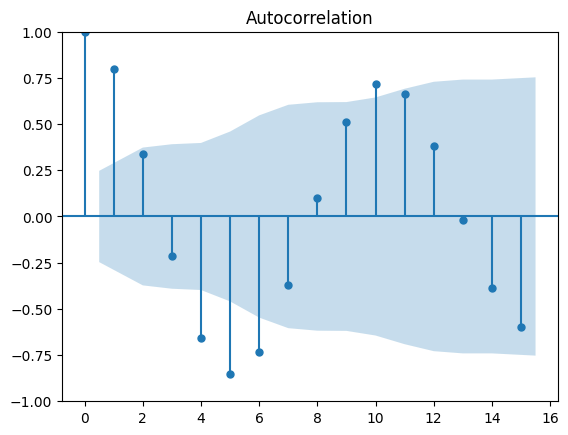

In [259]:
pacf=plot_pacf(avg_time, lags=15)
acf=plot_acf(avg_time, lags=15)

### plot between xt and xt-1 for avg time spent on mall each day

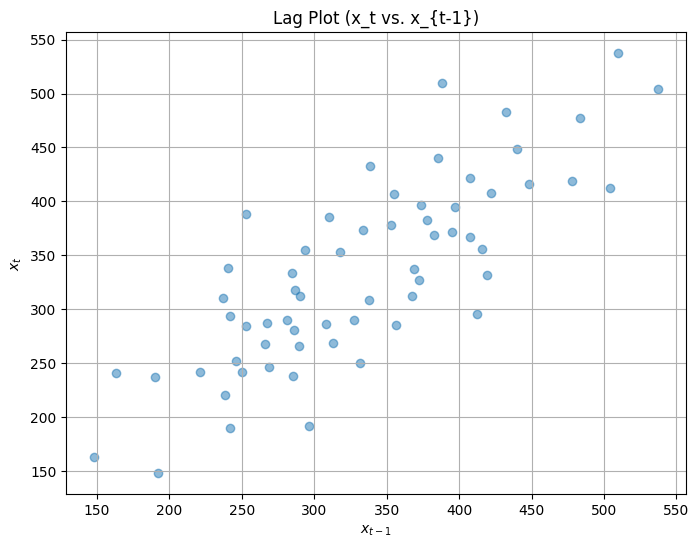

In [260]:

data = pd.Series(avg_time)  # assuming time series

# Create a DataFrame with `x_t` and `x_{t-1}`
df_lag = pd.DataFrame({'x_t': data, 'x_t-1': data.shift(1)})

# Drop NaN values caused by shifting
df_lag = df_lag.dropna()

# Plot x_t vs. x_{t-1}
plt.figure(figsize=(8, 6))
plt.scatter(df_lag['x_t-1'], df_lag['x_t'], alpha=0.5)
plt.title('Lag Plot (x_t vs. x_{t-1})')
plt.xlabel('$x_{t-1}$')
plt.ylabel('$x_{t}$')
plt.grid(True)
plt.show()

### checking for white noise in avg-time spent no mall each day

In [261]:
# Perform Ljung-Box test on residuals or data directly for white noise
result = acorr_ljungbox(data, lags=[10], return_df=True)
print(result)

       lb_stat     lb_pvalue
10  243.154308  1.490442e-46


### Training the ARIMA model on avg time spent by cars in mall each day

In [262]:

print(avg_time[len(avg_time)-10:])
train = avg_time[:len(avg_time)-7]
test = avg_time[len(avg_time)-7:]
# Define the order: (p, d, q)
# p = number of AR terms
# d = degree of differencing (usually set to 0 if the series is stationary)
# q = number of MA terms
order = (2, 1, 2) 

# Fit the ARIMA model
model = ARIMA(train, order=order).fit()


# Display the summary
print(model.summary())

[353.12855518 377.84722222 382.37825595 369.00878294 337.70700637
 308.43230404 286.05150215 280.93480935 290.06337136 312.09362809]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   56
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -214.012
Date:                Mon, 28 Oct 2024   AIC                            438.024
Time:                        18:08:00   BIC                            448.061
Sample:                             0   HQIC                           441.906
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6387      0.013    126.828      0.000       1.613       1.66

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### predicting avg-no of time spent by cars each on mall

[368.34018582 339.21680069 305.47071174 279.17137511 269.67858579
 280.31162487 307.18931502]


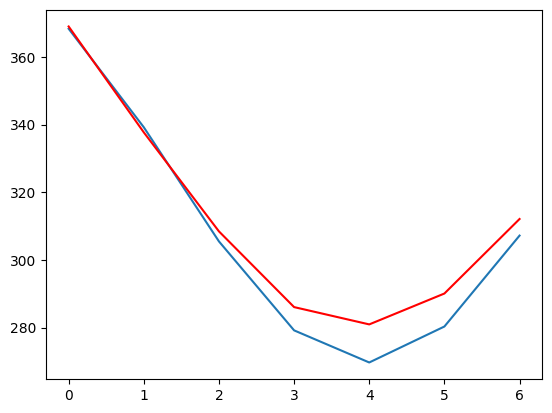

In [263]:
pred = model.predict(start=len(train), end=len(cars_)-1, dynamic=False)
print(pred)
plt.plot(pred)
plt.plot(test,color='r')

### Residual Analysis

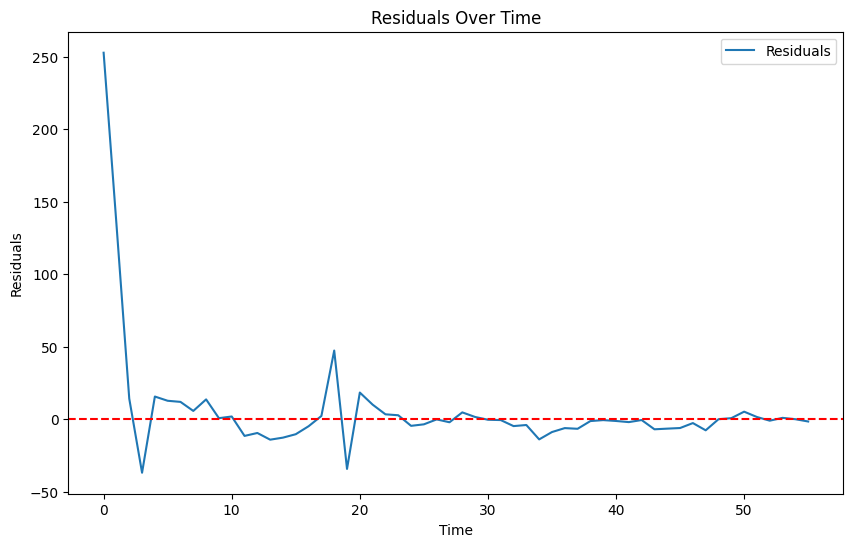

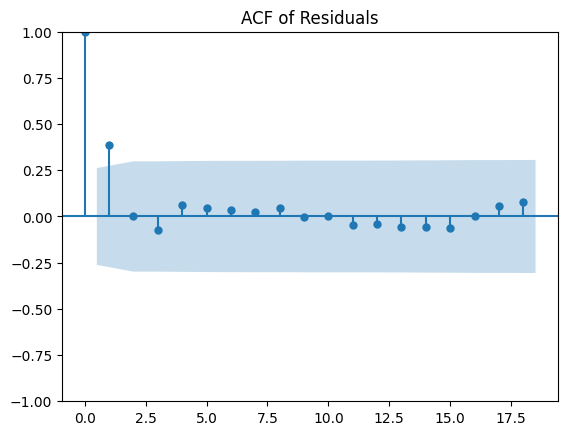

    lb_stat  lb_pvalue
10  9.82578   0.455909


In [264]:
fitted_values = model.fittedvalues  # Predicted values (in-sample forecast)
# Calculate residuals
residuals =  avg_time[:len(avg_time)-7] - fitted_values

plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()


plot_acf(residuals)
plt.title('ACF of Residuals')
plt.show()

from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_resid = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_resid)

### Calculating MASE and MAPE

In [265]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_scaled_error(y_true, y_pred):
    """Calculate Mean Absolute Scaled Error (MASE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    n = len(y_true)

    # Calculate MAE of the forecast
    mae_forecast = np.mean(np.abs(y_true - y_pred))
    
    # Calculate MAE of the naive forecast
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    
    return mae_forecast / mae_naive

mape_part_b = mean_absolute_percentage_error(test, pred)
mase_part_b = mean_absolute_scaled_error(test, pred)

print(f"MAPE: {mape_part_b:.2f}%")
print(f"MASE: {mase_part_b:.2f}")

MAPE: 1.85%
MASE: 0.27


### Future prediction of time spent on mall by visiting cars

In [266]:
pred_future = model.predict(start=len(cars_)+1, end=len(cars_)+7, dynamic=False)
# Convert predictions to integers
pred_future_values = pred_future.round().astype(int)

print("Future Prediction of time spent(minutes) in mall for the next week is: ")
print(pred_future_values)

Future Prediction of time spent(minutes) in mall for the next week is: 
[369 381 374 350 317 288 272]


# Part a

### Extracting the number of cars per day visit

<Axes: xlabel='timestamp'>

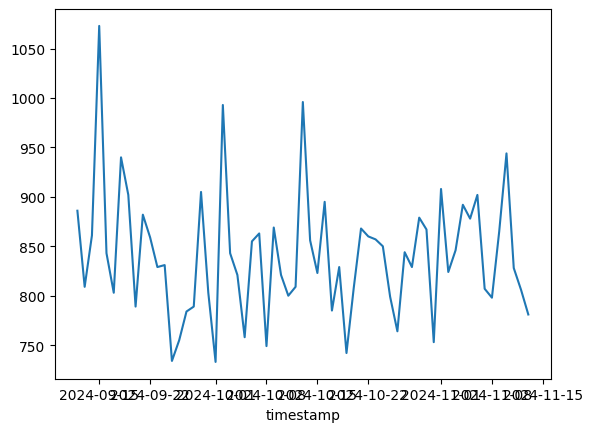

In [267]:
# Filter for entries only (camera_id = '001')
entries = df[df['camera_id'] == 1]

# Group by day and count unique vehicle entries
daily_entry_counts = entries.groupby(entries['timestamp'].dt.date)['vehicle_no'].nunique()
cars_ = daily_entry_counts.values

daily_entry_counts.plot()

### Analyzing the data for number of car visits per day

In [268]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(cars_, autolag='AIC')
print("1. ADF : ",dftest[0])
print("2. P-value : ",dftest[1])
print("3. Num of lags : ", dftest[2])
print("4. Num of observations used for ADF Regression and Critical Values Calculation: ", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t", key, ": ", val)

1. ADF :  -7.809375219207039
2. P-value :  7.137563791107939e-12
3. Num of lags :  0
4. Num of observations used for ADF Regression and Critical Values Calculation:  62
5. Critical Values :
	 1% :  -3.540522678829176
	 5% :  -2.9094272025108254
	 10% :  -2.5923136524453696


### ACF and PACF checking for avg car visit on mall each day

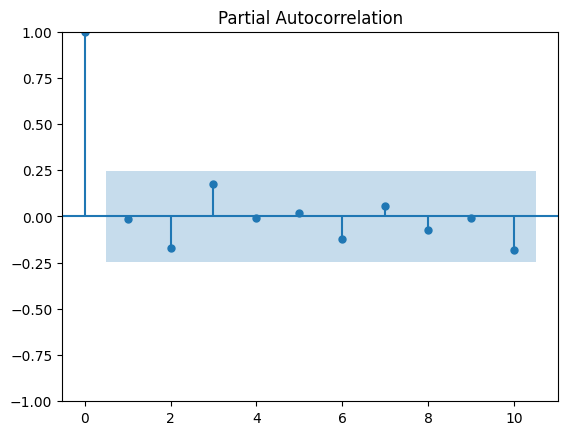

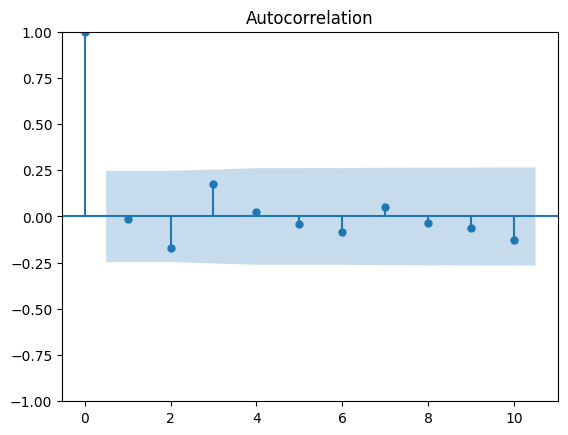

In [269]:
pacf=plot_pacf(cars_, lags=10)
acf=plot_acf(cars_, lags=10)

### plot between xt and one lag for avg-cars on mall each day

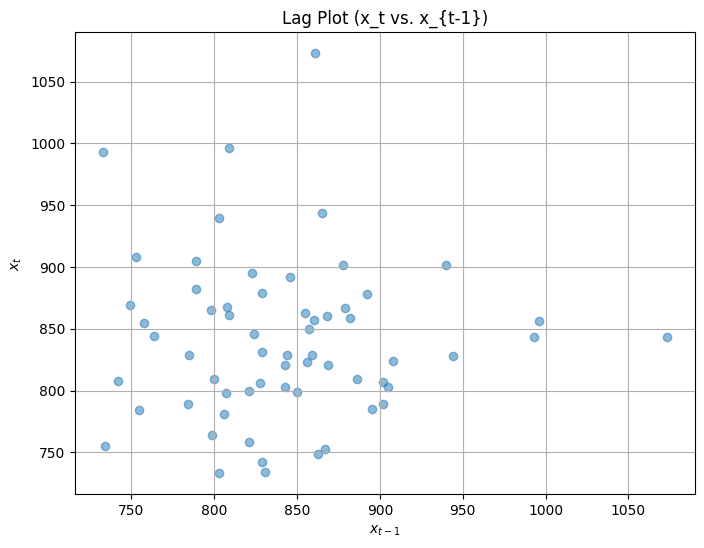

In [270]:
# Assuming `data` is your time series in a pandas Series format
data = pd.Series(cars_)  # Replace `cars_` with your actual time series

# Create a DataFrame with `x_t` and `x_{t-1}`
df_lag = pd.DataFrame({'x_t': data, 'x_t-1': data.shift(1)})

# Drop NaN values caused by shifting
df_lag = df_lag.dropna()

# Plot x_t vs. x_{t-1}
plt.figure(figsize=(8, 6))
plt.scatter(df_lag['x_t-1'], df_lag['x_t'], alpha=0.5)
plt.title('Lag Plot (x_t vs. x_{t-1})')
plt.xlabel('$x_{t-1}$')
plt.ylabel('$x_{t}$')
plt.grid(True)
plt.show()


### White noise-assumption confirmation
If the p-value is high, the null hypothesis (that series is white noise) cannot be rejected, reinforcing that the data is likely white noise.

In [271]:

# Perform Ljung-Box test on residuals or data directly for white noise
result = acorr_ljungbox(data, lags=[10], return_df=True)
print(result)

     lb_stat  lb_pvalue
10  6.645108    0.75847


### Training on ARIMA model for avg-car visit on mall each day

In [272]:


print(cars_[len(cars_)-10:])
train = cars_[:len(cars_)-7]
test = cars_[len(cars_)-7:]

order = (1, 1, 3)

# Fit the ARIMA model
model = ARIMA(train, order=order).fit()

# Display the summary
print(model.summary())


[892 878 902 807 798 865 944 828 806 781]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   56
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -306.577
Date:                Mon, 28 Oct 2024   AIC                            623.154
Time:                        18:08:02   BIC                            633.190
Sample:                             0   HQIC                           627.035
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6666      0.257     -2.591      0.010      -1.171      -0.162
ma.L1         -0.1725     70.232     -0.002      0.998    -137.825     137.480
ma.L2     

### Predicting on testing data interval and comparision in avg-car visit in mall each day

[814.300894   854.06543469 832.81100653 846.97849328 837.53492325
 843.82968933 839.63381003]


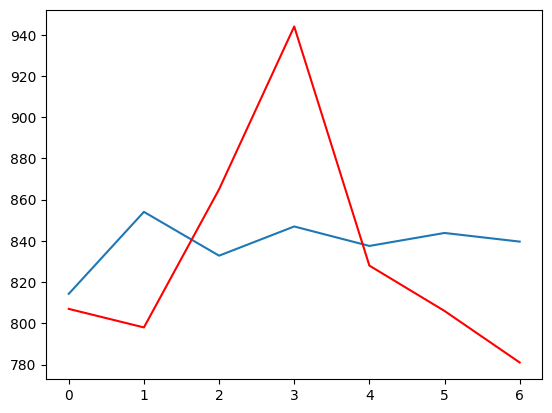

In [273]:
pred = model.predict(start=len(train), end=len(cars_)-1, dynamic=False)
print(pred)
plt.plot(pred)
plt.plot(test,color='r')

### residual analysis

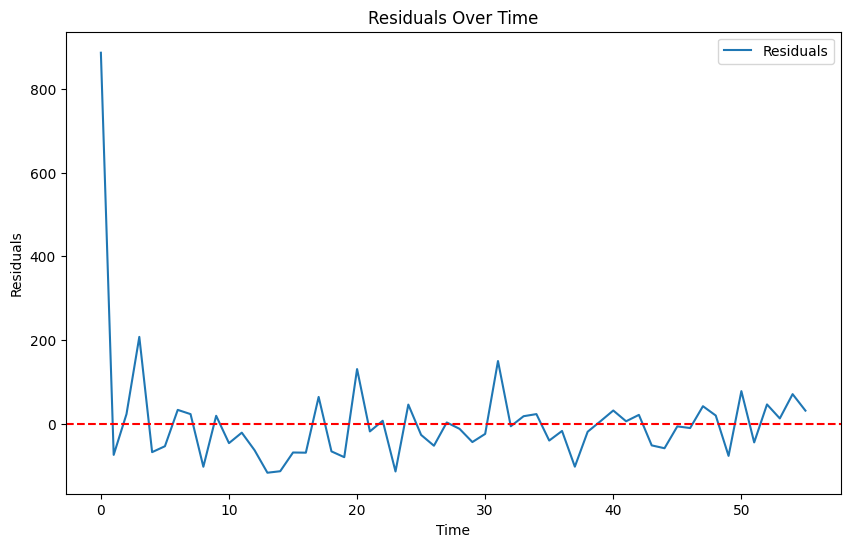

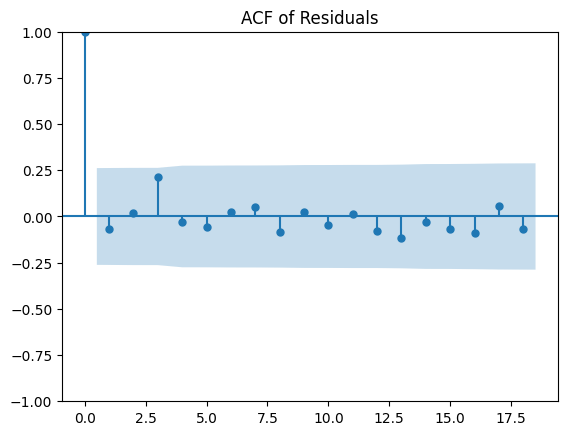

    lb_stat  lb_pvalue
10  4.22189   0.936782


In [274]:

fitted_values = model.fittedvalues  # Predicted values (in-sample forecast)
# Calculate residuals
residuals =  cars_[:len(cars_)-7] - fitted_values

plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()


plot_acf(residuals)
plt.title('ACF of Residuals')
plt.show()

from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_resid = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_resid)

### Calculating MASE and MAPE

In [275]:

mape_part_a = mean_absolute_percentage_error(test, pred)
mase_part_a = mean_absolute_scaled_error(test, pred)

print(f"MAPE: {mape_part_a:.2f}%")
print(f"MASE: {mase_part_a:.2f}")


MAPE: 5.04%
MASE: 0.80


### Making a future prediction

In [276]:
pred_future = model.predict(start=len(cars_)+1, end=len(cars_)+7, dynamic=False)
pred_future_values = pred_future.round().astype(int)

print("Future Prediction of cars visit in mall for the next week is: ")
print(pred_future_values)


Future Prediction of cars visit in mall for the next week is: 
[841 842 841 842 841 841 841]


### Average time spent calculation

In [277]:

# # Separate entries and exits
# entries = df[df['camera_id'] == 1].rename(columns={'timestamp': 'entry_time'})
# exits = df[df['camera_id'] == 2].rename(columns={'timestamp': 'exit_time'})

# print("-------------------------------entries----------------------------")
# print(entries.head())
# print(entries.shape)
# print("------------------------------exits--------------------------------")
# print(exits.head())
# print(exits.shape)


# # Merge entries and exits on 'vehicle_no'
# merged = pd.merge(entries, exits, on='vehicle_no')
# print("-----------------------------------------merged------------------------------------")
# print(merged.head())
# print(merged.shape)
# # Calculate time spent in the mall for each vehicle
# merged['time_spent'] = merged['exit_time'] - merged['entry_time']
# print("---------------------------------------merged again---------------------------------")
# print(merged.shape)
# print(merged.head())
# # Add a 'date' column for grouping by day of entry
# merged['date'] = merged['entry_time'].dt.date
# print("-------------------------------------merged last time------------------------------")
# print(merged.head())


# # Group by date and calculate average time spent per day
# daily_avg_time_spent = merged.groupby('date')['time_spent'].mean()

# print("Daily average time spent in the mall:\n", daily_avg_time_spent)


In [278]:
# # Separate entries and exits, and remove duplicates to maintain 1-to-1 matches
# entries = df[df['camera_id'] == 1].rename(columns={'timestamp': 'entry_time'}).drop_duplicates(subset=['vehicle_no', 'entry_time'])
# exits = df[df['camera_id'] == 2].rename(columns={'timestamp': 'exit_time'}).drop_duplicates(subset=['vehicle_no', 'exit_time'])

# # Merge entries and exits on 'vehicle_no' and ensure each entry has only the next exit
# merged = pd.merge(entries, exits, on='vehicle_no', suffixes=('_entry', '_exit'))

# # Calculate time spent in the mall and filter for valid durations
# merged['time_spent'] = merged['exit_time'] - merged['entry_time']
# merged = merged[(merged['time_spent'] > pd.Timedelta(0)) & (merged['entry_time'] < merged['exit_time'])]

# print("-------------merged--------------")
# print(merged.head())
# # Extract the date and calculate the average time spent per day
# merged['date'] = merged['entry_time'].dt.date
# daily_avg_time_spent = merged.groupby('date')['time_spent'].mean()

# print("Daily average time spent in the mall:\n", daily_avg_time_spent)




In [279]:
# Dictionary to track the latest status and timestamp of each vehicle
# seen_vehicles = {}
# time_threshold = pd.Timedelta(days=1)  # Define a threshold, e.g., 1 day, to reset vehicle entry status

# Custom function to fill missing 'camera_id' values
# def fill_camera_id(row, seen_vehicles):
#     if pd.isna(row['camera_id']):
#         vehicle = row['vehicle_no']
#         current_time = row['timestamp']
#         # Check if vehicle has been seen recently (within the time threshold)
#         if vehicle in seen_vehicles:
#             last_camera_id, last_time = seen_vehicles[vehicle]
#             # If the vehicle was last seen within the threshold, decide based on last entry
#             if current_time - last_time <= time_threshold and last_camera_id == 1:
#                 seen_vehicles[vehicle] = (2, current_time)
#                 return 2
        
#         # Otherwise, mark as new entry and update the dictionary
#         seen_vehicles[vehicle] = (1, current_time)
#         return 1
    
#     # If 'camera_id' is already present, update the dictionary with the current entry/exit
#     seen_vehicles[row['vehicle_no']] = (row['camera_id'], row['timestamp'])
#     return row['camera_id']

# # Apply function to each row to fill missing 'camera_id' based on vehicle history
# df['camera_id'] = df.apply(lambda row: fill_camera_id(row, seen_vehicles), axis=1)

# print(df.size)